# (29) HRF -- Apply & Save

**Motivation**: Apply gamma-variate HRF to CA data, save results with ```desc-hrf```. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
# from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


# Functions from Gabe:

# default time_length of 30sec as in Ma et al. 2016
def gamma_hrf(tr, oversampling=50, time_length=30., onset=0.,
                          delay=6, scale=1):
    """Generate a gamma hrf kernel
    Adapted from https://github.com/nilearn/nilearn/blob/9ddfa7259de3053a5ed6655cd662e115926cf6a5/nilearn/glm/first_level/hemodynamic_models.py#L18
    
    Parameters
    ----------
    tr : float
        Scan repeat time, in seconds.
    oversampling : int, optional
        Temporal oversampling factor.
        Default=50.
    time_length : float, optional
        hrf kernel length, in seconds.
        Default=32.
    onset : float, optional
        Onset time of the hrf. Default=0.
    delay : float, optional
        Delay parameter of the hrf (in s.).
        Default=6s.
    scale : float, optional
        Scale parameter of the hrf
        Default=1.
    Returns
    -------
    hrf : array of shape(length / tr * oversampling, dtype=float)
         hrf sampling on the oversampled time grid
    """
    dt = tr / oversampling
    time_stamps = np.linspace(
        0, time_length,
        np.rint(float(time_length) / dt).astype(int))
    time_stamps -= onset
    
    # time_stamps are the timepoints defining the time window of the kernel
    # a correspondings to the delay until the peak
    # loc defines when the function begins; equivalent to the onset, so it is set to 0
    # scale defines the width of the gamma function
    # free parameters are a and scale
    hrf = sp_stats.gamma.pdf(x=time_stamps, a=delay, loc=0, scale=scale)
    hrf /= hrf.sum()
    return hrf


def hrf_convolution(calcium_trace, gamma_delay, gamma_width, amplitude, onset):
    # inspired from https://github.com/nilearn/nilearn/blob/9ddfa7259de3053a5ed6655cd662e115926cf6a5/nilearn/glm/first_level/hemodynamic_models.py#L517

    # ignoring the oversampling since the 10Hz sampling of the calcium should be sufficient
    oversampling=1
    tr = 0.1 # the tr of 0.1Hz from calcium
    
    hkernel = gamma_hrf(tr, oversampling=oversampling, time_length=30., onset=onset,
                          delay=gamma_delay, scale=gamma_width)
    
    # dot product is applied with sliding window
    convolved = np.convolve(calcium_trace, hkernel)
    # extra timepoints are generated since the kernel is applied at the tail with missing timepoints; those extra timepoints are removed
    convolved = convolved[:calcium_trace.size]
    
    # final parameter managing the amplitude scaling
    convolved *= amplitude
        
    return convolved

## Setup

In [3]:
mice = Mice(512)
mice.setup_func_data(desc_ca2='preproc')

## Save

In [4]:
from register.preprocess import remove_badt_ca, butterworth

In [5]:
for k, f in tqdm(mice.ca.items()):
    data = f[:]
    data, ab, bad_t = remove_badt_ca(
        data=data,
        run_duration=mice.cfg.run_duration,
        exclude=mice.cfg.exclude,
        fs=mice.cfg.fs_ca,
    )
    mu, sd = data.mean(1), data.std(1)
    
    y = np_nans(data.shape)
    for i, x in enumerate(data):
        if np.isnan(mu[i]):
            continue
        y[i] = hrf_convolution(
            calcium_trace=(x - mu[i]) / sd[i],
            gamma_delay=2.6,
            gamma_width=1.2,
            amplitude=1,
            onset=0.4,
        )
    t = mice.cfg.run_duration * mice.cfg.fs_ca
    final = np_nans((len(y), t))
    
    t = np.zeros(t).astype(bool)
    t[ab] = True
    t[ab][bad_t] = False
    
    final[:, t] = y
    save_obj(
        obj=final,
        file_name=f.npy_file.replace('preproc', 'hrf'),
        save_dir=mice.cfg.ca_dir,
        verbose=False,
        mode='npy',
    )

100%|██████████| 111/111 [00:51<00:00,  2.16it/s]


In [6]:
k

'sub-SLC10_ses-3_run-7'

[<matplotlib.lines.Line2D object at 0x7f9574d74160>]

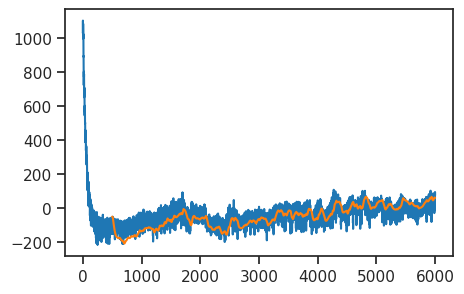

In [13]:
plt.plot(np.nanmean(f[:], 0))
plt.plot((np.nanmean(final, 0) - 0.5) * 100)

In [12]:
k

'sub-SLC05_ses-1_run-5'

In [24]:
x = np.nanmean(final, 0)
x = x[np.isfinite(x)]
a = butterworth(x, (0.01, 0.5), 10)
b = butterworth(x, 0.5, 10)

[<matplotlib.lines.Line2D object at 0x7f956b059460>]

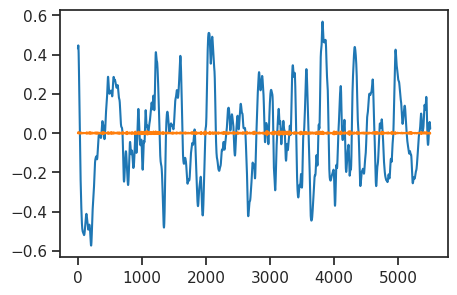

In [26]:
plt.plot(a)
plt.plot(b)

[<matplotlib.lines.Line2D object at 0x7f94a8aa3eb0>]

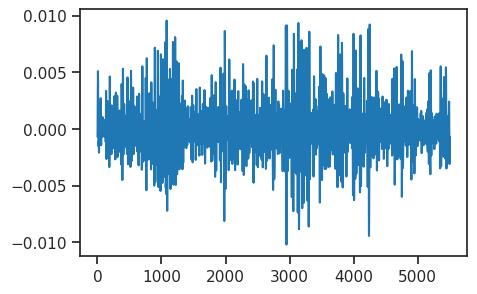

In [28]:
plt.plot(b)

## Draft

In [8]:
final.shape

(540, 6000)

<matplotlib.image.AxesImage object at 0x7f2face4cdf0>

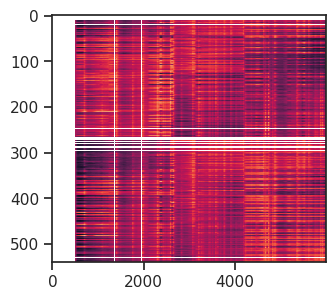

In [9]:
plt.imshow(final, aspect=10)

In [10]:
_data, _ab, _bad_t = remove_badt_ca(
    data=final,
    run_duration=mice.cfg.run_duration,
    exclude=mice.cfg.exclude,
    fs=mice.cfg.fs_ca,
)

<matplotlib.image.AxesImage object at 0x7f2facd77c10>

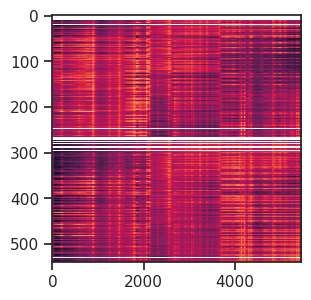

In [11]:
plt.imshow(_data, aspect=10)

In [12]:
_bad_t.sum()

43

In [14]:
collections.Counter(np.isnan(_data).sum(1))

Counter({5457: 44, 0: 496})

<Axes: ylabel='Count'>

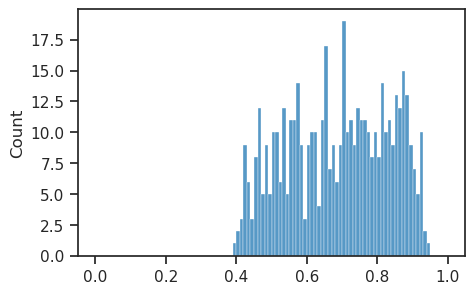

In [21]:
sns.histplot(_data.std(1), bins=np.linspace(0, 1, 101))

<Axes: ylabel='Count'>

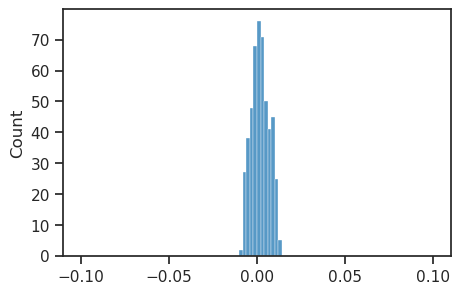

In [19]:
sns.histplot(_data.mean(1), bins=np.linspace(-0.1, 0.1, 101))

In [126]:
__data = final[:, _ab]
# filter out outliers (spikes)
gs = bn.nanmean(__data, 0)

[<matplotlib.lines.Line2D object at 0x7f82208a7af0>]

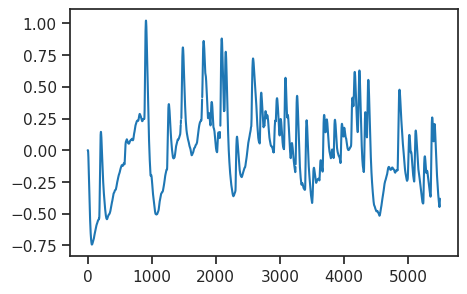

In [127]:
plt.plot(gs)

In [131]:
().sum()

43

[<matplotlib.lines.Line2D object at 0x7f8220aa6700>]

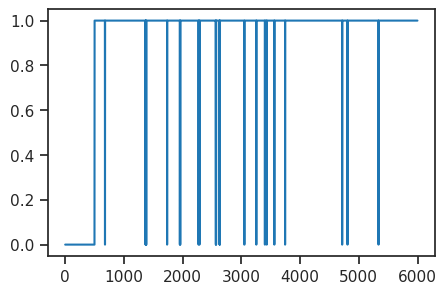

In [115]:
plt.plot(t)

[<matplotlib.lines.Line2D object at 0x7f8220afdd30>]

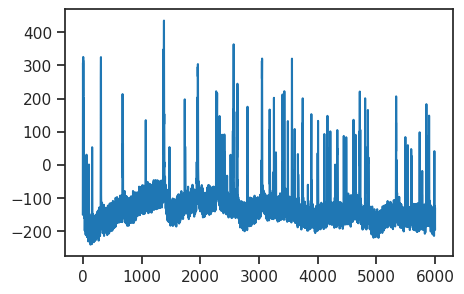

In [113]:
plt.plot(np.nanmean(f[:], 0))

In [30]:
y.shape

(540, 5457)

In [31]:
data.shape

(540, 5457)

[<matplotlib.lines.Line2D object at 0x7f8238ffa940>]

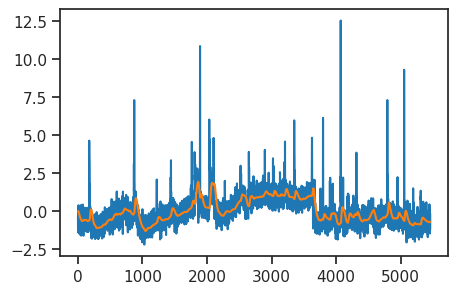

In [37]:
plt.plot((data[30] - mu[30]) / sd[30])
plt.plot(y[30])

In [45]:
sp_stats.pearsonr((data[30] - mu[30]) / sd[30], y[30])

PearsonRResult(statistic=0.6366529718152851, pvalue=0.0)

In [46]:
aaa = butterworth((data[30] - mu[30]) / sd[30], (0.01, 0.5), 10)
bbb = butterworth(y[30], (0.01, 0.5), 10)

0.3431669825603891

[<matplotlib.lines.Line2D object at 0x7f822f42dcd0>]

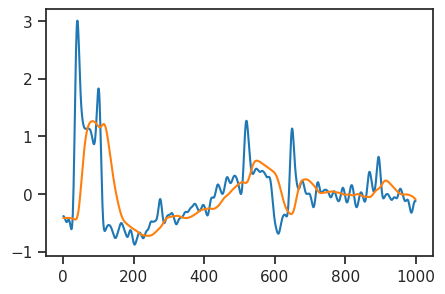

In [52]:
plt.plot(aaa[2000:3000])
plt.plot(bbb[2000:3000]);

In [85]:
span = np.arange(-500, 501)
r = np.zeros(span.shape)
rr = np.zeros(span.shape)
for i, t in enumerate(span):
    r[i] = sp_stats.pearsonr(np.roll(aaa, t), bbb).statistic
    rr[i] = sp_stats.pearsonr(np.roll((data[30] - mu[30]) / sd[30], t), y[30]).statistic

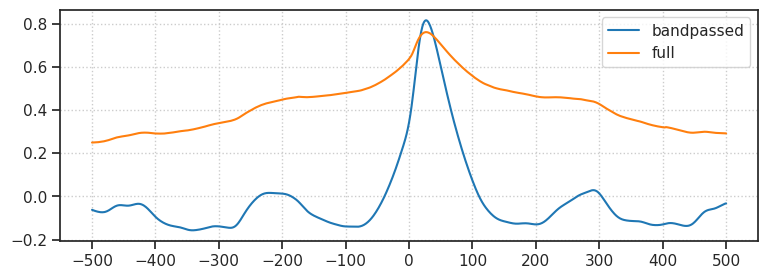

In [86]:
fig, ax = create_figure(1, 1, (9, 3))
ax.plot(span, r, label='bandpassed')
ax.plot(span, rr, label='full')
ax.grid()
ax.legend()
ax.locator_params(axis='x', nbins=20)

[<matplotlib.lines.Line2D object at 0x7f82535da1c0>]

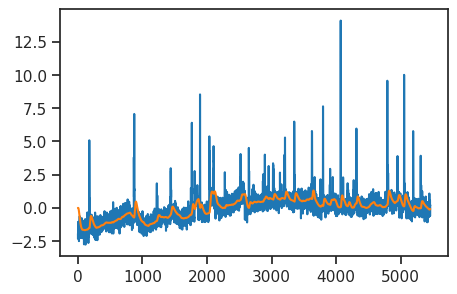

In [26]:
plt.plot((x - mu[i]) / sd[i])
plt.plot(y[0])

In [10]:
data = f[:]
y = np_nans(data.shape)


In [12]:
x.shape

(6000,)

In [15]:
mu, sd

(-33.618934155273436, 107.38943623674838)

In [ ]:
i = 100

plt.plot(y);

In [20]:
initial_offset = 500

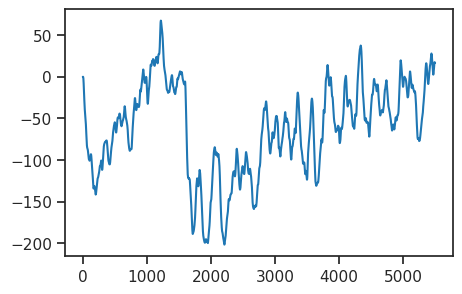

In [21]:
i = 100
y = hrf_convolution(
    calcium_trace=x[i][initial_offset:],
    gamma_delay=2.6,
    gamma_width=1.2,
    amplitude=1,
    onset=0.4,
)
plt.plot(y);

In [22]:
y.shape

(5500,)

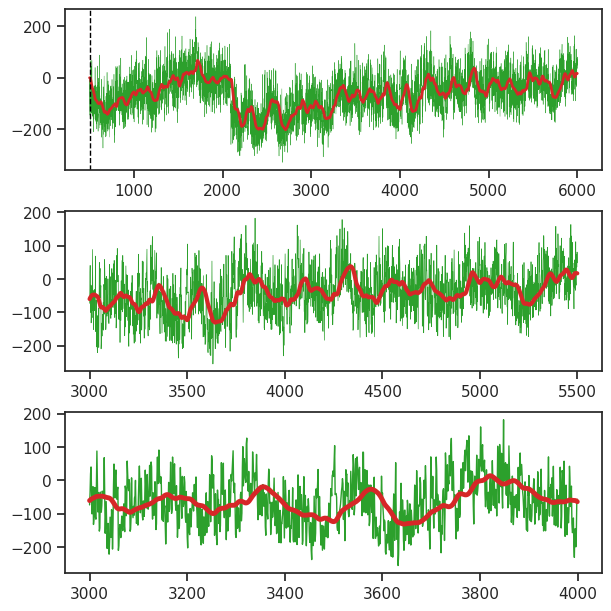

In [23]:
fig, axes = create_figure(3, 1, (6, 6), sharex='none', sharey='none', layout='constrained')

intvl = range(initial_offset, 6000)
axes[0].plot(intvl, x[i][intvl], color='C2', lw=0.3)
axes[0].plot(intvl, y, color='C3', lw=2.0)
axes[0].axvline(500, color='k', ls='--', lw=1.0)

intvl = np.array(range(3000, 5500))
axes[1].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=0.5)
axes[1].plot(intvl, y[intvl], color='C3', lw=3)

intvl = np.array(range(3000, 4000))
axes[2].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=1.0)
axes[2].plot(intvl, y[intvl], color='C3', lw=3.5)
plt.show()

In [24]:
initial_offset = 0

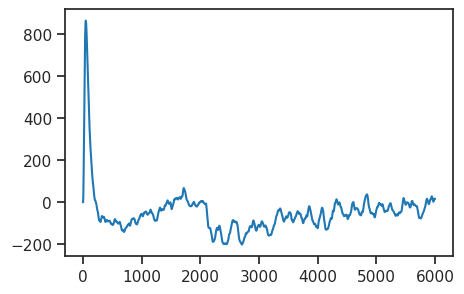

In [25]:
i = 100
y = hrf_convolution(
    calcium_trace=x[i][initial_offset:],
    gamma_delay=2.6,
    gamma_width=1.2,
    amplitude=1,
    onset=0.4,
)
plt.plot(y);

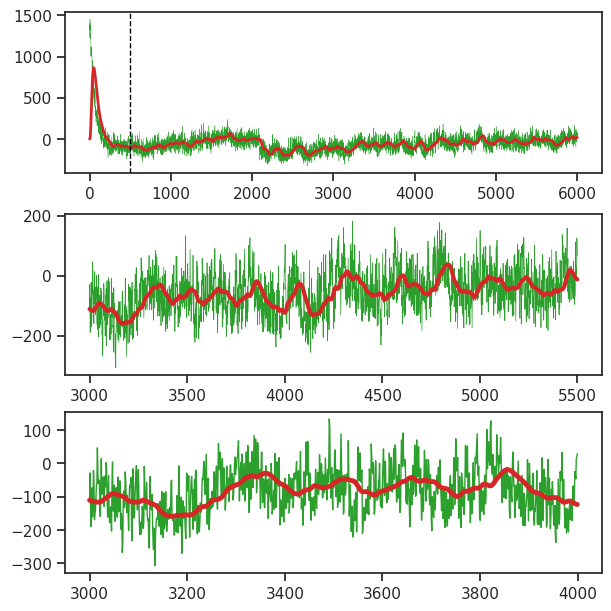

In [26]:
fig, axes = create_figure(3, 1, (6, 6), sharex='none', sharey='none', layout='constrained')

intvl = range(initial_offset, 6000)
axes[0].plot(intvl, x[i][intvl], color='C2', lw=0.3)
axes[0].plot(intvl, y, color='C3', lw=2.0)
axes[0].axvline(500, color='k', ls='--', lw=1.0)

intvl = np.array(range(3000, 5500))
axes[1].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=0.5)
axes[1].plot(intvl, y[intvl], color='C3', lw=3)

intvl = np.array(range(3000, 4000))
axes[2].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=1.0)
axes[2].plot(intvl, y[intvl], color='C3', lw=3.5)
plt.show()

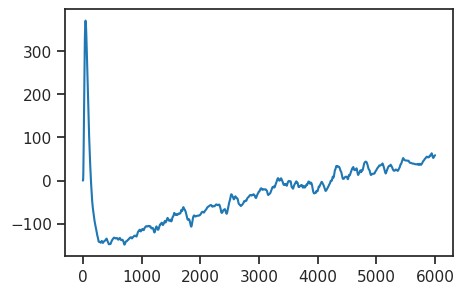

In [27]:
i = 120
y = hrf_convolution(
    calcium_trace=x[i][initial_offset:],
    gamma_delay=2.6,
    gamma_width=1.2,
    amplitude=1,
    onset=0.4,
)
plt.plot(y);

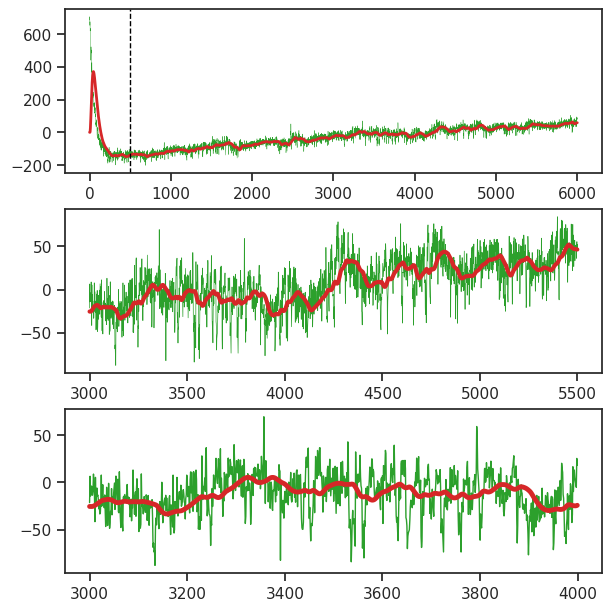

In [28]:
fig, axes = create_figure(3, 1, (6, 6), sharex='none', sharey='none', layout='constrained')

intvl = range(initial_offset, 6000)
axes[0].plot(intvl, x[i][intvl], color='C2', lw=0.3)
axes[0].plot(intvl, y, color='C3', lw=2.0)
axes[0].axvline(500, color='k', ls='--', lw=1.0)

intvl = np.array(range(3000, 5500))
axes[1].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=0.5)
axes[1].plot(intvl, y[intvl], color='C3', lw=3)

intvl = np.array(range(3000, 4000))
axes[2].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=1.0)
axes[2].plot(intvl, y[intvl], color='C3', lw=3.5)
plt.show()